In [ ]:
# Library imports
import sys
import os
sys.path.append(os.path.abspath(r"C:\Users\kriti\OneDrive\Desktop\Python\Historical Simulation\src"))

In [ ]:
# Module imports
from load_data import load_data
from returns import calculate_log_returns
from pnl import calculate_pnl
from portfolio import compute_portfolio_returns
from hs_risk import historical_simulation_risk
from backtesting import var_backtest
from basel_traffic_light import basel_traffic_lights

In [ ]:
# Load price data
prices = load_data("../data/prices.csv")
prices.head()

,AAPL,AMZN,GOOGL,GS,JPM,META,MS,MSFT,TSLA
Date,,,,,,,,,
2020-01-02,72.468277,94.900497,67.920807,203.182602,119.036430,208.324783,43.069691,152.505692,28.684000
2020-01-03,71.763725,93.748497,67.565498,200.806702,117.465576,207.222504,42.374489,150.606705,29.534000
2020-01-06,72.335556,95.143997,69.366386,202.861740,117.372154,211.125229,42.225517,150.996002,30.102667
2020-01-07,71.995369,95.343002,69.232407,204.197128,115.376747,211.582031,42.142750,149.619247,31.270666
2020-01-08,73.153503,94.598503,69.725182,206.165451,116.276833,213.727051,42.680710,152.002441,32.809334


In [ ]:
# Calculate log returns
log_returns = calculate_log_returns(prices)
log_returns.head()

,AAPL,AMZN,GOOGL,GS,JPM,META,MS,MSFT,TSLA
Date,,,,,,,,,
2020-01-03,-0.009770,-0.012213,-0.005245,-0.011762,-0.013284,-0.005305,-0.016273,-0.012530,0.029203
2020-01-06,0.007937,0.014776,0.026305,0.010182,-0.000796,0.018658,-0.003522,0.002582,0.019072
2020-01-07,-0.004714,0.002089,-0.001933,0.006561,-0.017147,0.002161,-0.001962,-0.009160,0.038067
2020-01-08,0.015958,-0.007839,0.007092,0.009593,0.007771,0.010087,0.012684,0.015803,0.048033
2020-01-09,0.021018,0.004788,0.010443,0.020152,0.003644,0.014210,0.009457,0.012416,-0.022189


In [ ]:
# Define portfolio weights
import pandas as pd
weights = {
    "AAPL": 0.15,
    "MSFT": 0.15,
    "MS": 0.10,
    "GS": 0.10,
    "AMZN": 0.10,
    "GOOGL": 0.10,
    "META": 0.10,
    "TSLA": 0.10,
    "JPM": 0.10
}
weights = pd.Series(weights)
print(weights.sum())
weights = weights.loc[log_returns.columns]

1.0


In [ ]:
# Compute portfolio returns
portfolio_returns = compute_portfolio_returns(log_returns, weights)
portfolio_returns.head()

Date
2020-01-03   -0.006833
2020-01-06    0.010045
2020-01-07    0.000703
2020-01-08    0.013506
2020-01-09    0.009066
dtype: float64

In [ ]:
# Calculate Historical Simulation VaR
portfolio_value = 1_000_000_000
pnl = calculate_pnl(portfolio_returns, portfolio_value)
pnl_mn = (pnl / 1e6).to_frame("Daily P&L (USD mn)")
pnl_mn.round(2).head()

,Daily P&L (USD mn)
Date,
2020-01-03,-6.83
2020-01-06,10.05
2020-01-07,0.70
2020-01-08,13.51
2020-01-09,9.07


In [ ]:
# Calculate risk metrics
risk_metrics = historical_simulation_risk(pnl, window = 250, confidence_level=0.99)
import pandas as pd
pd.options.display.float_format = "{:.4f}".format
risk_metrics.head()

,VaR,ES
Date,,
2020-12-30,92363978.7025,115019992.9663
2020-12-31,92363978.7025,115019992.9663
2021-01-04,92363978.7025,115019992.9663
2021-01-05,92363978.7025,115019992.9663
2021-01-06,92363978.7025,115019992.9663


In [ ]:
# Backtest VaR
summary, breach_table = var_backtest(pnl, risk_metrics["VaR"])
summary["Breach Ratio (%)"] = (summary["Breach Ratio"] * 100).round(2)
summary = summary.drop(columns="Breach Ratio")
summary

,Total Observations,Number of Breaches,Breach Ratio (%)
0,1256,22,1.7500


In [ ]:
# Basel Traffic Light Summary
breach_count = summary["Number of Breaches"].iloc[0]
result = basel_traffic_lights(breach_count, 0.99)
print("Basel Traffic Light Summary")
print("-" * 35)
print(f"Zone              : {result['Zone']}")
print(f"Capital Multiplier: {result['Capital Multiplier']}")
print(f"Number of Breaches: {int(result['Breaches'])}")

Basel Traffic Light Summary
-----------------------------------
Zone              : Red
Capital Multiplier: 4
Number of Breaches: 22


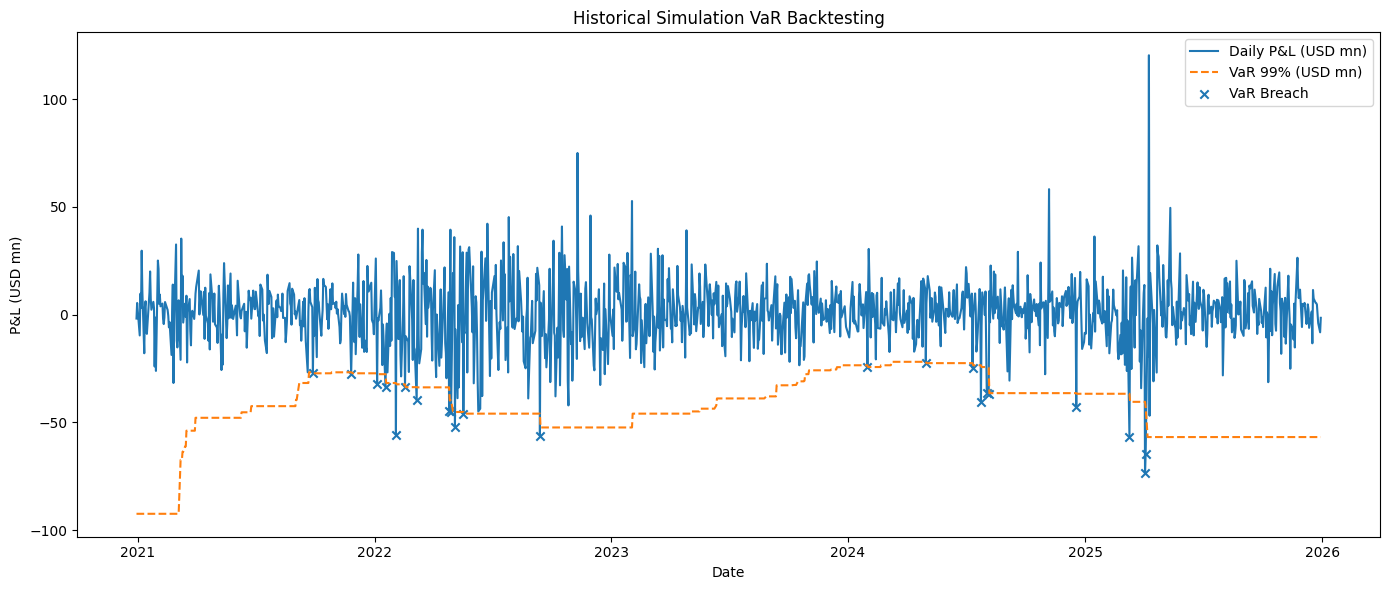

In [ ]:
# Visualization 
import matplotlib.pyplot as plt

# Align data
plot_data = pd.concat(
    [pnl, risk_metrics["VaR"]],
    axis=1
).dropna()

plot_data.columns = ["PnL", "VaR"]

# Identify breaches
plot_data["Breach"] = plot_data["PnL"] < -plot_data["VaR"]

# Convert to USD millions for clean visualization
plot_data["PnL"] = plot_data["PnL"] / 1e6
plot_data["VaR"] = plot_data["VaR"] / 1e6

# Plot
plt.figure(figsize=(14, 6))

plt.plot(
    plot_data.index,
    plot_data["PnL"],
    label="Daily P&L (USD mn)"
)

plt.plot(
    plot_data.index,
    -plot_data["VaR"],
    linestyle="--",
    label="VaR 99% (USD mn)"
)

# Highlight breaches
plt.scatter(
    plot_data.index[plot_data["Breach"]],
    plot_data["PnL"][plot_data["Breach"]],
    marker="x",
    label="VaR Breach"
)

plt.title("Historical Simulation VaR Backtesting")
plt.xlabel("Date")
plt.ylabel("P&L (USD mn)")
plt.legend()
plt.tight_layout()
plt.show()


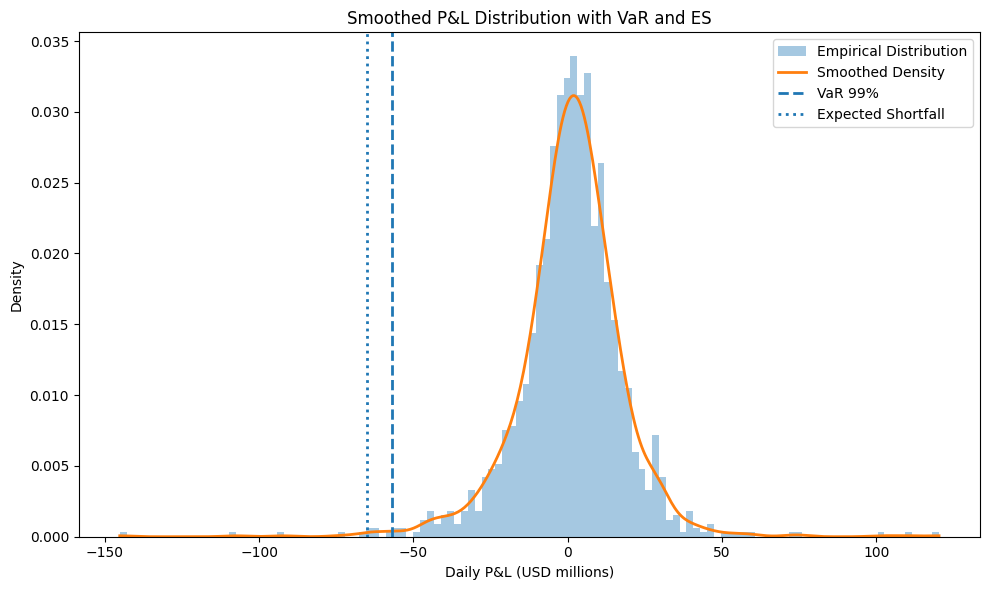

In [ ]:
# P&L Distribution with VaR and ES
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Convert to USD millions
pnl_mn = pnl / 1e6

# Latest VaR and ES
latest_var = risk_metrics["VaR"].iloc[-1] / 1e6
latest_es = risk_metrics["ES"].iloc[-1] / 1e6

plt.figure(figsize=(10, 6))

# Histogram (more bins = flatter)
plt.hist(
    pnl_mn,
    bins=120,
    density=True,
    alpha=0.4,
    label="Empirical Distribution"
)

# KDE smoothing
kde = gaussian_kde(pnl_mn)
x = np.linspace(pnl_mn.min(), pnl_mn.max(), 500)
plt.plot(x, kde(x), linewidth=2, label="Smoothed Density")

# VaR & ES lines
plt.axvline(-latest_var, linestyle="--", linewidth=2, label="VaR 99%")
plt.axvline(-latest_es, linestyle=":", linewidth=2, label="Expected Shortfall")

plt.title("Smoothed P&L Distribution with VaR and ES")
plt.xlabel("Daily P&L (USD millions)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()